In [1]:
%matplotlib inline
%load_ext fortranmagic

import sys; sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc('figure', figsize=(12, 7))

ran_the_first_cell = True

jan2017 = pd.to_datetime(['2017-01-03 00:00:00+00:00',
 '2017-01-04 00:00:00+00:00',
 '2017-01-05 00:00:00+00:00',
 '2017-01-06 00:00:00+00:00',
 '2017-01-09 00:00:00+00:00',
 '2017-01-10 00:00:00+00:00',
 '2017-01-11 00:00:00+00:00',
 '2017-01-12 00:00:00+00:00',
 '2017-01-13 00:00:00+00:00',
 '2017-01-17 00:00:00+00:00',
 '2017-01-18 00:00:00+00:00',
 '2017-01-19 00:00:00+00:00',
 '2017-01-20 00:00:00+00:00',
 '2017-01-23 00:00:00+00:00',
 '2017-01-24 00:00:00+00:00',
 '2017-01-25 00:00:00+00:00',
 '2017-01-26 00:00:00+00:00',
 '2017-01-27 00:00:00+00:00',
 '2017-01-30 00:00:00+00:00',
 '2017-01-31 00:00:00+00:00',
 '2017-02-01 00:00:00+00:00'])
calendar = jan2017.values.astype('datetime64[D]')

event_dates = pd.to_datetime(['2017-01-06 00:00:00+00:00', 
                             '2017-01-07 00:00:00+00:00', 
                             '2017-01-08 00:00:00+00:00']).values.astype('datetime64[D]')
event_values = np.array([10, 15, 20])

/home/ssanderson/projects/pydata-toolbox/venv/lib/python3.5/site-packages/fortranmagic.py:147: UserWarning: get_ipython_cache_dir has moved to the IPython.paths module since IPython 4.0.
  self._lib_dir = os.path.join(get_ipython_cache_dir(), 'fortran')


<center>
  <h1>The PyData Toolbox</h1>
  <h3>Scott Sanderson (Twitter: @scottbsanderson, GitHub: ssanderson)</h3>
  <h3><a href="https://github.com/ssanderson/pydata-toolbox">https://github.com/ssanderson/pydata-toolbox</a></h3>
</center>

# About Me:

<img src="images/me.jpg" alt="Drawing" style="width: 300px;"/>

- Senior Engineer at [Quantopian](www.quantopian.com)
- Background in Mathematics and Philosophy
- **Twitter:** [@scottbsanderson](https://twitter.com/scottbsanderson)
- **GitHub:** [ssanderson](github.com/ssanderson)

## Outline

- Built-in Data Structures
- Numpy `array`
- Pandas `Series`/`DataFrame`
- Plotting and "Real-World" Analyses

# Data Structures

> Rule 5. Data dominates. If you've chosen the right data structures and organized things well, the algorithms
will almost always be self-evident. Data structures, not algorithms, are central to programming.

- *Notes on Programming in C*, by Rob Pike.

# Lists

In [2]:
assert ran_the_first_cell, "Oh noes!"

In [3]:
l = [1, 'two', 3.0, 4, 5.0, "six"]
l

[1, 'two', 3.0, 4, 5.0, 'six']

In [4]:
# Lists can be indexed like C-style arrays.
first = l[0]
second = l[1]
print("first:", first)
print("second:", second)

first: 1
second: two


In [5]:
# Negative indexing gives elements relative to the end of the list.
last = l[-1]
penultimate = l[-2]
print("last:", last)
print("second to last:", penultimate)

last: six
second to last: 5.0


In [6]:
# Lists can also be sliced, which makes a copy of elements between 
# start (inclusive) and stop (exclusive)
sublist = l[1:3]
sublist

['two', 3.0]

In [7]:
# l[:N] is equivalent to l[0:N].
first_three = l[:3]
first_three

[1, 'two', 3.0]

In [8]:
# l[3:] is equivalent to l[3:len(l)].
after_three = l[3:]
after_three

[4, 5.0, 'six']

In [9]:
# There's also a third parameter, "step", which gets every Nth element.
l = ['a', 'b', 'c', 'd', 'e', 'f', 'g','h']
l[1:7:2]

['b', 'd', 'f']

In [10]:
# This is a cute way to reverse a list.
l[::-1]

['h', 'g', 'f', 'e', 'd', 'c', 'b', 'a']

In [11]:
# Lists can be grown efficiently (in O(1) amortized time).
l = [1, 2, 3, 4, 5]
print("Before:", l)
l.append('six')
print("After:", l)

Before: [1, 2, 3, 4, 5]
After: [1, 2, 3, 4, 5, 'six']


In [12]:
# Comprehensions let us perform elementwise computations.
l = [1, 2, 3, 4, 5]
[x * 2 for x in l]

[2, 4, 6, 8, 10]

## Review: Python Lists

- Zero-indexed sequence of arbitrary Python values.
- Slicing syntax: `l[start:stop:step]` copies elements at regular intervals from `start` to `stop`.
- Efficient (`O(1)`) appends and removes from end.
- Comprehension syntax: `[f(x) for x in l if cond(x)]`.

# Dictionaries

In [13]:
# Dictionaries are key-value mappings.
philosophers = {'David': 'Hume', 'Immanuel': 'Kant', 'Bertrand': 'Russell'}
philosophers

{'Bertrand': 'Russell', 'David': 'Hume', 'Immanuel': 'Kant'}

In [14]:
# Like lists, dictionaries are size-mutable.
philosophers['Ludwig'] = 'Wittgenstein'
philosophers

{'Bertrand': 'Russell',
 'David': 'Hume',
 'Immanuel': 'Kant',
 'Ludwig': 'Wittgenstein'}

In [15]:
del philosophers['David']
philosophers

{'Bertrand': 'Russell', 'Immanuel': 'Kant', 'Ludwig': 'Wittgenstein'}

In [16]:
# No slicing.
philosophers['Bertrand':'Immanuel']

TypeError: unhashable type: 'slice'

## Review: Python Dictionaries

- Unordered key-value mapping from (almost) arbitrary keys to arbitrary values.
- Efficient (`O(1)`) lookup, insertion, and deletion.
- No slicing (would require a notion of order).

<center><img src="images/pacino.gif" alt="Drawing" style="width: 100%;"/></center>


In [17]:
# Suppose we have some matrices...
a = [[1, 2, 3],
     [2, 3, 4],
     [5, 6, 7],
     [1, 1, 1]]

b = [[1, 2, 3, 4],
     [2, 3, 4, 5]]

In [18]:
def matmul(A, B):
    """Multiply matrix A by matrix B."""
    rows_out = len(A)
    cols_out = len(B[0])
    out = [[0 for col in range(cols_out)] for row in range(rows_out)]
    
    for i in range(rows_out):
        for j in range(cols_out):
            for k in range(len(B)):
                out[i][j] += A[i][k] * B[k][j]
    return out

<center><img src="images/gross.gif" alt="Drawing" style="width: 50%;"/></center>


In [19]:
%%time

matmul(a, b)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21 µs


[[5, 8, 11, 14], [8, 13, 18, 23], [17, 28, 39, 50], [3, 5, 7, 9]]

In [20]:
import random
def random_matrix(m, n):
    out = []
    for row in range(m):
        out.append([random.random() for _ in range(n)])
    return out

randm = random_matrix(2, 3)
randm

[[0.1284400577047189, 0.7430538602191037, 0.5982267683657111],
 [0.15040193996829998, 0.37133534561680825, 0.9791613789073683]]

In [21]:
%%time
randa = random_matrix(600, 100)
randb = random_matrix(100, 600)
x = matmul(randa, randb)

CPU times: user 5.99 s, sys: 4 ms, total: 5.99 s
Wall time: 5.99 s


In [22]:
# Maybe that's not that bad?  Let's try a simpler case.
def python_dot_product(xs, ys):
    return sum(x * y for x, y in zip(xs, ys))

In [23]:
%%fortran
subroutine fortran_dot_product(xs, ys, result)
    double precision, intent(in) :: xs(:)
    double precision, intent(in) :: ys(:)
    double precision, intent(out) :: result
    
    result = sum(xs * ys)
end

In [24]:
list_data = [float(i) for i in range(100000)]
array_data = np.array(list_data)

In [25]:
%%time
python_dot_product(list_data, list_data)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 6.95 ms


333328333350000.0

In [26]:
%%time
fortran_dot_product(array_data, array_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 181 µs


333328333350000.0

<center><img src="images/sloth.gif" alt="Drawing" style="width: 1080px;"/></center>


## Why is the Python Version so Much Slower?

In [27]:
# Dynamic typing.
def mul_elemwise(xs, ys):
    return [x * y for x, y in zip(xs, ys)]

mul_elemwise([1, 2, 3, 4], [1, 2 + 0j, 3.0, 'four'])
#[type(x) for x in _]

[1, (4+0j), 9.0, 'fourfourfourfour']

In [28]:
# Interpretation overhead.
source_code = 'a + b * c'
bytecode = compile(source_code, '', 'eval')
import dis; dis.dis(bytecode)

  1           0 LOAD_NAME                0 (a)
              3 LOAD_NAME                1 (b)
              6 LOAD_NAME                2 (c)
              9 BINARY_MULTIPLY
             10 BINARY_ADD
             11 RETURN_VALUE


## Why is the Python Version so Slow?
- Dynamic typing means that every single operation requires dispatching on the input type.
- Having an interpreter means that every instruction is fetched and dispatched at runtime.
- Other overheads:
  - Arbitrary-size integers.
  - Reference-counted garbage collection.

> This is the paradox that we have to work with when we're doing scientific or numerically-intensive Python. What makes Python fast for development -- this high-level, interpreted, and dynamically-typed aspect of the language -- is exactly what makes it slow for code execution.

- Jake VanderPlas, [*Losing Your Loops: Fast Numerical Computing with NumPy*](https://www.youtube.com/watch?v=EEUXKG97YRw)

# What Do We Do?

<center><img src="images/runaway.gif" alt="Drawing" style="width: 50%;"/></center>

<center><img src="images/thisisfine.gif" alt="Drawing" style="width: 1080px;"/></center>

- Python is slow for numerical computation because it performs dynamic dispatch on every operation we perform...

- ...but often, we just want to do the same thing over and over in a loop!

- If we don't need Python's dynamicism, we don't want to pay (much) for it.

- **Idea:** Dispatch **once per operation** instead of **once per element**.

In [29]:
import numpy as np

data = np.array([1, 2, 3, 4])
data

array([1, 2, 3, 4])

In [30]:
data + data

array([2, 4, 6, 8])

In [31]:
%%time
# Naive dot product
(array_data * array_data).sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 408 µs


333328333350000.0

In [32]:
%%time
# Built-in dot product.
array_data.dot(array_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 162 µs


333328333350000.0

In [33]:
%%time
fortran_dot_product(array_data, array_data)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 313 µs


333328333350000.0

In [34]:
# Numpy won't allow us to write a string into an int array.
data[0] = "foo"

ValueError: invalid literal for int() with base 10: 'foo'

In [ ]:
# We also can't grow an array once it's created.
data.append(3)

In [ ]:
# We **can** reshape an array though.
two_by_two = data.reshape(2, 2)
two_by_two

Numpy arrays are:

- Fixed-type

- Size-immutable

- Multi-dimensional

- Fast\*

\* If you use them correctly.

# What's in an Array?

In [35]:
arr = np.array([1, 2, 3, 4, 5, 6], dtype='int16').reshape(2, 3)
print("Array:\n", arr, sep='')
print("===========")
print("DType:", arr.dtype)
print("Shape:", arr.shape)
print("Strides:", arr.strides)
print("Data:", arr.data.tobytes())

Array:
[[1 2 3]
 [4 5 6]]
DType: int16
Shape: (2, 3)
Strides: (6, 2)
Data: b'\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00'


# Core Operations

- Vectorized **ufuncs** for elementwise operations.
- Fancy indexing and masking for selection and filtering.
- Aggregations across axes.
- Broadcasting

# UFuncs

UFuncs (universal functions) are functions that operate elementwise on one or more arrays.

In [36]:
data = np.arange(15).reshape(3, 5)
data

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [37]:
# Binary operators.
data * data

array([[  0,   1,   4,   9,  16],
       [ 25,  36,  49,  64,  81],
       [100, 121, 144, 169, 196]])

In [38]:
# Unary functions.
np.sqrt(data)

array([[ 0.        ,  1.        ,  1.41421356,  1.73205081,  2.        ],
       [ 2.23606798,  2.44948974,  2.64575131,  2.82842712,  3.        ],
       [ 3.16227766,  3.31662479,  3.46410162,  3.60555128,  3.74165739]])

In [39]:
# Comparison operations
(data % 3) == 0

array([[ True, False, False,  True, False],
       [False,  True, False, False,  True],
       [False, False,  True, False, False]], dtype=bool)

In [40]:
# Boolean combinators.
((data % 2) == 0) & ((data % 3) == 0)

array([[ True, False, False, False, False],
       [False,  True, False, False, False],
       [False, False,  True, False, False]], dtype=bool)

In [41]:
# as of python 3.5, @ is matrix-multiply
data @ data.T

array([[ 30,  80, 130],
       [ 80, 255, 430],
       [130, 430, 730]])

# UFuncs Review

- UFuncs provide efficient elementwise operations applied across one or more arrays.
- Arithmetic Operators (`+`, `*`, `/`)
- Comparisons (`==`, `>`, `!=`)
- Boolean Operators (`&`, `|`, `^`)
- Trigonometric Functions (`sin`, `cos`)
- Transcendental Functions (`exp`, `log`)

# Selections

We often want to perform an operation on just a subset of our data.

In [42]:
sines = np.sin(np.linspace(0, 3.14, 10))
cosines = np.cos(np.linspace(0, 3.14, 10))
sines

array([ 0.        ,  0.34185385,  0.64251645,  0.86575984,  0.98468459,
        0.98496101,  0.8665558 ,  0.64373604,  0.34335012,  0.00159265])

In [43]:
# Slicing works with the same semantics as Python lists.
sines[0]

0.0

In [44]:
sines[:3]  # First three elements  

array([ 0.        ,  0.34185385,  0.64251645])

In [45]:
sines[5:]  # Elements from 5 on.

array([ 0.98496101,  0.8665558 ,  0.64373604,  0.34335012,  0.00159265])

In [46]:
sines[::2]  # Every other element.

array([ 0.        ,  0.64251645,  0.98468459,  0.8665558 ,  0.34335012])

In [47]:
# More interesting: we can index with boolean arrays to filter by a predicate.
print("sines:\n", sines)
print("sines > 0.5:\n", sines > 0.5)
print("sines[sines > 0.5]:\n", sines[sines > 0.5])

sines:
 [ 0.          0.34185385  0.64251645  0.86575984  0.98468459  0.98496101
  0.8665558   0.64373604  0.34335012  0.00159265]
sines > 0.5:
 [False False  True  True  True  True  True  True False False]
sines[sines > 0.5]:
 [ 0.64251645  0.86575984  0.98468459  0.98496101  0.8665558   0.64373604]


In [48]:
# We index with lists/arrays of integers to select values at those indices.
print(sines)
sines[[0, 4, 7]]

[ 0.          0.34185385  0.64251645  0.86575984  0.98468459  0.98496101
  0.8665558   0.64373604  0.34335012  0.00159265]


array([ 0.        ,  0.98468459,  0.64373604])

In [49]:
# Index arrays are often used for sorting one or more arrays.
unsorted_data = np.array([1, 3, 2, 12, -1, 5, 2])

In [50]:
sort_indices = np.argsort(unsorted_data)
sort_indices

array([4, 0, 2, 6, 1, 5, 3])

In [51]:
unsorted_data[sort_indices]

array([-1,  1,  2,  2,  3,  5, 12])

In [52]:
market_caps = np.array([12, 6, 10, 5, 6])  # Presumably in dollars?
assets = np.array(['A', 'B', 'C', 'D', 'E'])

In [53]:
# Sort assets by market cap by using the permutation that would sort market caps on ``assets``.
sort_by_mcap = np.argsort(market_caps)
assets[sort_by_mcap]

array(['D', 'B', 'E', 'C', 'A'],
      dtype='<U1')

In [54]:
# Indexers are also useful for aligning data.
print("Dates:\n", repr(event_dates))
print("Values:\n", repr(event_values))
print("Calendar:\n", repr(calendar))

Dates:
 array(['2017-01-06', '2017-01-07', '2017-01-08'], dtype='datetime64[D]')
Values:
 array([10, 15, 20])
Calendar:
 array(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
       '2017-01-09', '2017-01-10', '2017-01-11', '2017-01-12',
       '2017-01-13', '2017-01-17', '2017-01-18', '2017-01-19',
       '2017-01-20', '2017-01-23', '2017-01-24', '2017-01-25',
       '2017-01-26', '2017-01-27', '2017-01-30', '2017-01-31', '2017-02-01'], dtype='datetime64[D]')


In [55]:
print("Raw Dates:", event_dates)
print("Indices:", calendar.searchsorted(event_dates))
print("Forward-Filled Dates:", calendar[calendar.searchsorted(event_dates)])

Raw Dates: ['2017-01-06' '2017-01-07' '2017-01-08']
Indices: [3 4 4]
Forward-Filled Dates: ['2017-01-06' '2017-01-09' '2017-01-09']


On multi-dimensional arrays, we can slice along each axis independently.

In [56]:
data = np.arange(25).reshape(5, 5)
data

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14],
       [15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24]])

In [57]:
data[:2, :2]  # First two rows and first two columns.

array([[0, 1],
       [5, 6]])

In [58]:
data[:2, [0, -1]]  # First two rows, first and last columns.

array([[0, 4],
       [5, 9]])

In [59]:
data[(data[:, 0] % 2) == 0]  # Rows where the first column is divisible by two.

array([[ 0,  1,  2,  3,  4],
       [10, 11, 12, 13, 14],
       [20, 21, 22, 23, 24]])

# Selections Review

- Indexing with an integer removes a dimension.
- Slicing operations work on Numpy arrays the same way they do on lists.
- Indexing with a boolean array filters to True locations.
- Indexing with an integer array selects indices along an axis.
- Multidimensional arrays can apply selections independently along different axes.

## Reductions

Functions that reduce an array to a scalar.

$Var(X) = \frac{1}{N}\sqrt{\sum_{i=1}^N (x_i - \bar{x})^2}$

In [60]:
def variance(x):
    return ((x - x.mean()) ** 2).sum() / len(x)

In [61]:
variance(np.random.standard_normal(1000))

1.0638195544963331

- `sum()` and `mean()` are both **reductions**.

- In the simplest case, we use these to reduce an entire array into a single value...

In [62]:
data = np.arange(30)
data.mean()

14.5

- ...but we can do more interesting things with multi-dimensional arrays.

In [63]:
data = np.arange(30).reshape(3, 10)
data

array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
       [20, 21, 22, 23, 24, 25, 26, 27, 28, 29]])

In [64]:
data.mean()

14.5

In [65]:
data.mean(axis=0)

array([ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.])

In [66]:
data.mean(axis=1)

array([  4.5,  14.5,  24.5])

## Reductions Review

- Reductions allow us to perform efficient aggregations over arrays.
- We can do aggregations over a single axis to collapse a single dimension.
- Many built-in reductions (`mean`, `sum`, `min`, `max`, `median`, ...).

# Broadcasting

In [67]:
row = np.array([1, 2, 3, 4])
column = np.array([[1], [2], [3]])
print("Row:\n", row, sep='')
print("Column:\n", column, sep='')

Row:
[1 2 3 4]
Column:
[[1]
 [2]
 [3]]


In [68]:
row + column

array([[2, 3, 4, 5],
       [3, 4, 5, 6],
       [4, 5, 6, 7]])

<center><img src="images/broadcasting.png" alt="Drawing" style="width: 60%;"/></center>

<h5>Source: http://www.scipy-lectures.org/_images/numpy_broadcasting.png</h5>

In [69]:
# Broadcasting is particularly useful in conjunction with reductions.
print("Data:\n", data, sep='')
print("Mean:\n", data.mean(axis=0), sep='')
print("Data - Mean:\n", data - data.mean(axis=0), sep='')

Data:
[[ 0  1  2  3  4  5  6  7  8  9]
 [10 11 12 13 14 15 16 17 18 19]
 [20 21 22 23 24 25 26 27 28 29]]
Mean:
[ 10.  11.  12.  13.  14.  15.  16.  17.  18.  19.]
Data - Mean:
[[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [ 10.  10.  10.  10.  10.  10.  10.  10.  10.  10.]]


# Broadcasting Review

- Numpy operations can work on arrays of different dimensions as long as the arrays' shapes are still "compatible".
- Broadcasting works by "tiling" the smaller array along the missing dimension.
- The result of a broadcasted operation is always at least as large in each dimension as the largest array in that dimension.

# Numpy Review

- Numerical algorithms are slow in pure Python because the overhead dynamic dispatch dominates our runtime.

- Numpy solves this problem by:
  1. Imposing additional restrictions on the contents of arrays.
  2. Moving the inner loops of our algorithms into compiled C code.

- Using Numpy effectively often requires reworking an algorithms to use vectorized operations instead of for-loops, but the resulting operations are usually simpler, clearer, and faster than the pure Python equivalent.

<center><img src="images/unicorn.jpg" alt="Drawing" style="width: 75%;"/></center>

Numpy is great for many things, but...

- Sometimes our data is equipped with a natural set of **labels**:
  - Dates/Times
  - Stock Tickers
  - Field Names (e.g. Open/High/Low/Close)

- Sometimes we have **more than one type of data** that we want to keep grouped together.
  - Tables with a mix of real-valued and categorical data.

- Sometimes we have **missing** data, which we need to ignore, fill, or otherwise work around.

<center><img src="images/panda-wrangling.gif" alt="Drawing" style="width: 75%;"/></center>

<center><img src="images/pandas_logo.png" alt="Drawing" style="width: 75%;"/></center>


Pandas extends Numpy with more complex data structures:

- `Series`: 1-dimensional, homogenously-typed, labelled array.
- `DataFrame`: 2-dimensional, semi-homogenous, labelled table.

Pandas also provides many utilities for: 
- Input/Output
- Data Cleaning
- Rolling Algorithms
- Plotting

# Selection in Pandas

In [70]:
s = pd.Series(index=['a', 'b', 'c', 'd', 'e'], data=[1, 2, 3, 4, 5])
s

a    1
b    2
c    3
d    4
e    5
dtype: int64

In [71]:
# There are two pieces to a Series: the index and the values.
print("The index is:", s.index)
print("The values are:", s.values)

The index is: Index(['a', 'b', 'c', 'd', 'e'], dtype='object')
The values are: [1 2 3 4 5]


In [72]:
# We can look up values out of a Series by position...
s.iloc[0]

1

In [73]:
# ... or by label.
s.loc['a']

1

In [74]:
# Slicing works as expected...
s.iloc[:2]

a    1
b    2
dtype: int64

In [75]:
# ...but it works with labels too!
s.loc[:'c']

a    1
b    2
c    3
dtype: int64

In [76]:
# Fancy indexing works the same as in numpy.
s.iloc[[0, -1]]

a    1
e    5
dtype: int64

In [77]:
# As does boolean masking.
s.loc[s > 2]

c    3
d    4
e    5
dtype: int64

In [78]:
# Element-wise operations are aligned by index.
other_s = pd.Series({'a': 10.0, 'c': 20.0, 'd': 30.0, 'z': 40.0})
other_s

a    10.0
c    20.0
d    30.0
z    40.0
dtype: float64

In [79]:
s + other_s

a    11.0
b     NaN
c    23.0
d    34.0
e     NaN
z     NaN
dtype: float64

In [80]:
# We can fill in missing values with fillna().
(s + other_s).fillna(0.0)

a    11.0
b     0.0
c    23.0
d    34.0
e     0.0
z     0.0
dtype: float64

In [81]:
# Most real datasets are read in from an external file format.
aapl = pd.read_csv('AAPL.csv', parse_dates=['Date'], index_col='Date')
aapl.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2010-01-04,27.613066,30.572857,30.642857,30.340000,30.490000,123432400.0
2010-01-05,27.660807,30.625713,30.798571,30.464285,30.657143,150476200.0
2010-01-06,27.220825,30.138571,30.747143,30.107143,30.625713,138040000.0
2010-01-07,27.170504,30.082857,30.285715,29.864286,30.250000,119282800.0
2010-01-08,27.351143,30.282858,30.285715,29.865715,30.042856,111902700.0


In [82]:
# Slicing generalizes to two dimensions as you'd expect:
aapl.iloc[:2, :2]

,Adj Close,Close
Date,,
2010-01-04,27.613066,30.572857
2010-01-05,27.660807,30.625713


In [83]:
aapl.loc[pd.Timestamp('2010-02-01'):pd.Timestamp('2010-02-04'), ['Close', 'Volume']]

,Close,Volume
Date,,
2010-02-01,27.818571,187469100.0
2010-02-02,27.980000,174585600.0
2010-02-03,28.461428,153832000.0
2010-02-04,27.435715,189413000.0


# Rolling Operations

<center><img src="images/rolling.gif" alt="Drawing" style="width: 75%;"/></center>

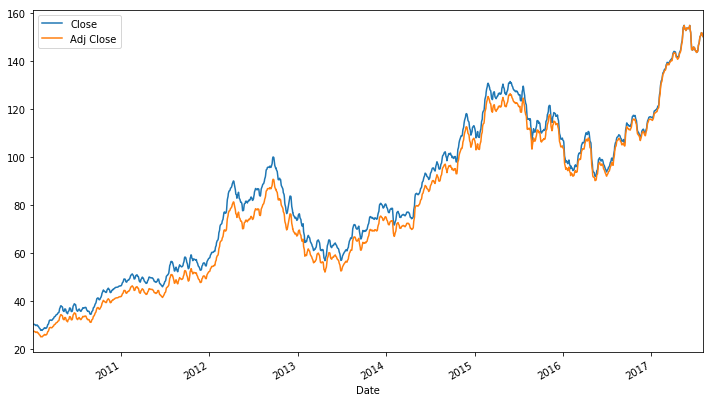

In [89]:
aapl.rolling(5)[['Close', 'Adj Close']].mean().plot();

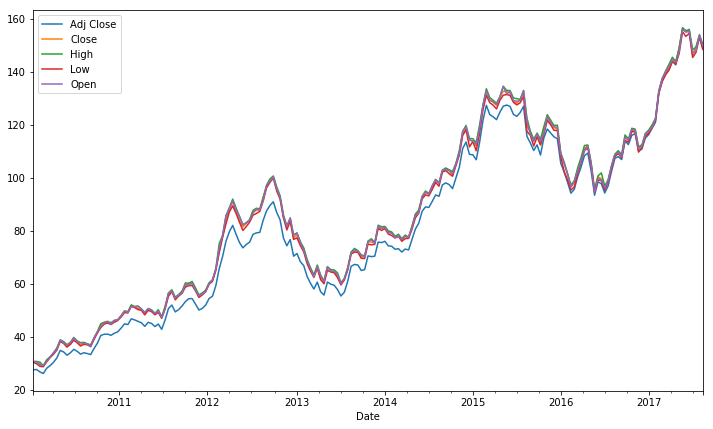

In [90]:
# Drop `Volume`, since it's way bigger than everything else.
aapl.drop('Volume', axis=1).resample('2W').max().plot();

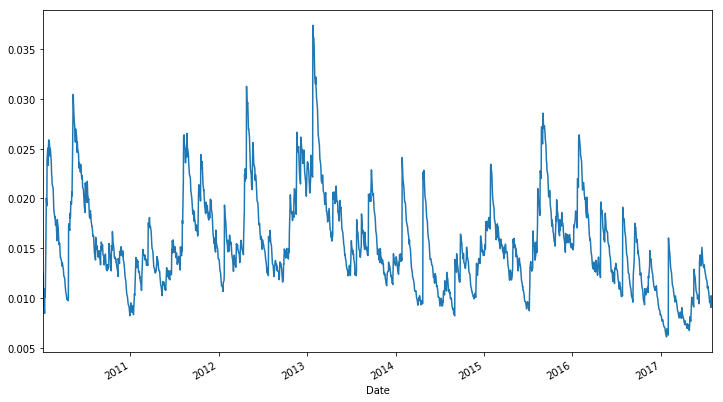

In [91]:
# 30-day rolling exponentially-weighted stddev of returns.
aapl['Close'].pct_change().ewm(span=30).std().plot();

# "Real World" Data

In [95]:
from demos.avocados import read_avocadata

avocados = read_avocadata('2014', '2016')
avocados.head()

,Date,Region,Variety,Organic,Number of Stores,Weighted Avg Price,Low Price,High Price
0,2014-01-03 00:00:00+00:00,NATIONAL,HASS,False,9184,0.93,NaN,NaN
1,2014-01-03 00:00:00+00:00,NATIONAL,HASS,True,872,1.44,NaN,NaN
2,2014-01-03 00:00:00+00:00,NORTHEAST,HASS,False,1449,1.08,0.5,1.67
3,2014-01-03 00:00:00+00:00,NORTHEAST,HASS,True,66,1.54,1.5,2.00
4,2014-01-03 00:00:00+00:00,SOUTHEAST,HASS,False,2286,0.98,0.5,1.99


In [96]:
# Unlike numpy arrays, pandas DataFrames can have a different dtype for each column.
avocados.dtypes

Date                  datetime64[ns, UTC]
Region                             object
Variety                            object
Organic                              bool
Number of Stores                    int64
Weighted Avg Price                float64
Low Price                         float64
High Price                        float64
dtype: object

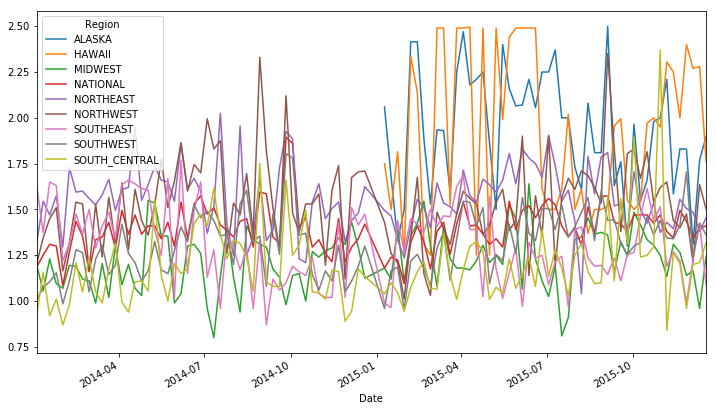

In [97]:
# What's the regional average price of a HASS avocado every day?
hass = avocados[avocados.Variety == 'HASS']
hass.groupby(['Date', 'Region'])['Weighted Avg Price'].mean().unstack().ffill().plot();

In [98]:
def _organic_spread(group):

    if len(group.columns) != 2:
        return pd.Series(index=group.index, data=0.0)
    
    is_organic = group.columns.get_level_values('Organic').values.astype(bool)
    organics = group.loc[:, is_organic].squeeze()
    non_organics = group.loc[:, ~is_organic].squeeze()
    diff = organics - non_organics
    return diff

def organic_spread_by_region(df):
    """What's the difference between the price of an organic 
    and non-organic avocado within each region?
    """
    return (
        df
        .set_index(['Date', 'Region', 'Organic'])
         ['Weighted Avg Price']
        .unstack(level=['Region', 'Organic'])
        .ffill()
        .groupby(level='Region', axis=1)
        .apply(_organic_spread)
    )

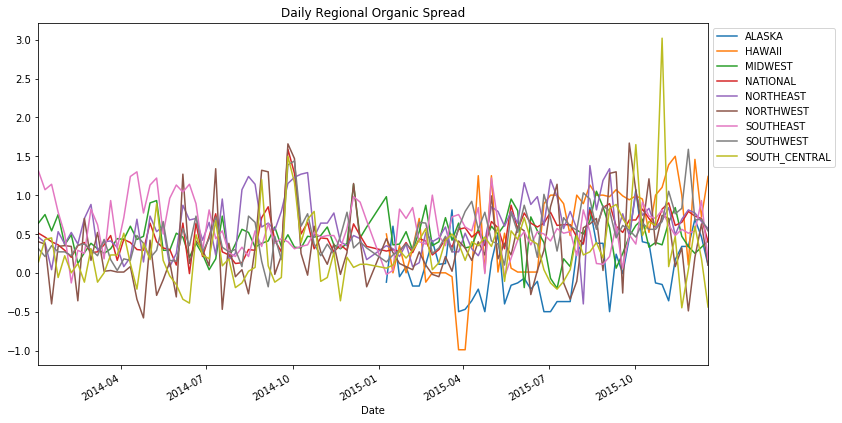

In [102]:
organic_spread_by_region(hass).plot();
plt.gca().set_title("Daily Regional Organic Spread");
plt.legend(bbox_to_anchor=(1, 1));

In [100]:
spread_correlation = organic_spread_by_region(hass).corr()
spread_correlation

Region,ALASKA,HAWAII,MIDWEST,NATIONAL,NORTHEAST,NORTHWEST,SOUTHEAST,SOUTHWEST,SOUTH_CENTRAL
Region,,,,,,,,,
ALASKA,1.000000,0.202723,0.175251,0.007844,0.051049,0.087575,0.129079,-0.070868,0.161624
HAWAII,0.202723,1.000000,-0.021116,0.373914,0.247171,0.341155,0.019388,0.159192,0.092632
MIDWEST,0.175251,-0.021116,1.000000,0.062595,-0.010213,-0.043783,0.047437,-0.059128,0.068902
NATIONAL,0.007844,0.373914,0.062595,1.000000,0.502035,0.579102,-0.040539,0.635006,0.486524
NORTHEAST,0.051049,0.247171,-0.010213,0.502035,1.000000,0.242039,-0.236225,0.360389,0.149881
NORTHWEST,0.087575,0.341155,-0.043783,0.579102,0.242039,1.000000,-0.032306,0.165992,0.349935
SOUTHEAST,0.129079,0.019388,0.047437,-0.040539,-0.236225,-0.032306,1.000000,-0.167631,-0.021176
SOUTHWEST,-0.070868,0.159192,-0.059128,0.635006,0.360389,0.165992,-0.167631,1.000000,0.254504
SOUTH_CENTRAL,0.161624,0.092632,0.068902,0.486524,0.149881,0.349935,-0.021176,0.254504,1.000000


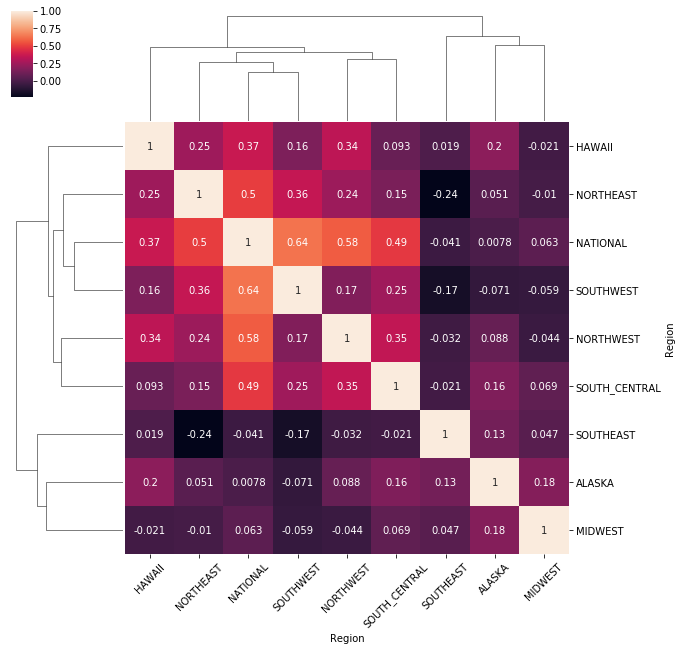

In [149]:
import seaborn as sns
grid = sns.clustermap(spread_correlation, annot=True)
fig = grid.fig
axes = fig.axes
ax = axes[2]
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

# Pandas Review

- Pandas extends numpy with more complex datastructures and algorithms.
- If you understand numpy, you understand 90% of pandas.
- `groupby`, `set_index`, and `unstack` are powerful tools for working with categorical data.
- Avocado prices are surprisingly interesting :)

# Thanks!